## Jean-Eudes Rouffiac  

&nbsp;

&nbsp;

# <center> TP 1 : Introduction au Machine Learning </center>

L'objectif de ce premier TP est double : 
* mettre en oeuvre une démarche d'analyse et traitement des données sur des applications simples
* s'initier à la programmation orientée Machine Learning en Python avec NumPy et ScikitLearn

# Données iris

Le but est de construire une méthode permettant de prédire à partir de caractéristiques biologiques le type de fleurs iris. Les données décrivant les fleurs sont codées dans une matrice $X \in \mathbb{R}^{150\times 4}$ dont les colones sont respectivement : 
* longueur du sépale (cm)
* largeur du sépale (cm)
* longueur du pétale (cm)
* largeur du pétale (cm)
  
Chaque ligne de $X$ correspond à une fleur. Les labels des fleurs sont encodés dans un vecteur $y \in \mathbb{R}^{150}$. Il y a trois types de fleurs : 
* Iris Setosa (label=0)
* Iris Versicolour (label=1)
* Iris Virginia (label = 2)

&nbsp;

Dans un premier temps, nous importons les différents packages qui vont nous permettre d'effectuer le TP.

In [678]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

&nbsp;

Grâce à la fonction *load_iris()* mise à disposition par *sklearn*, on importe les données.

In [679]:
from sklearn import datasets
iris = datasets.load_iris()

&nbsp;

On stocke alors les variables explicatives dans une matrice $X$ et les types de fleurs (les labels) dans un vecteur $Y$. On affiche ensuite les dimensions de $X$ et $Y$ pour s'assurer qu'ils ont bien une taille conforme à la description des données.

In [907]:
X = iris.data
Y = iris.target
print(X.shape)
print(Y.shape)

(150, 4)
(150,)




&nbsp;
<p style="text-align:justify;"> Avant de mettre en place une méthode de classification des données, il faut prendre en main le jeu de données et donc faire l'étape de pre-traitement des données afin d'identifier d'éventuelles données incomplètes ou bien des données aberrantes. Dans notre cas, toutes les données sont complètes.  


Visualisons maintenant les données en 2D pour chaque paire de descripteurs (données de $X$). Sur les graphiques, seront représentés de couleurs différentes les trois types de fleur (données de $Y$). </p>


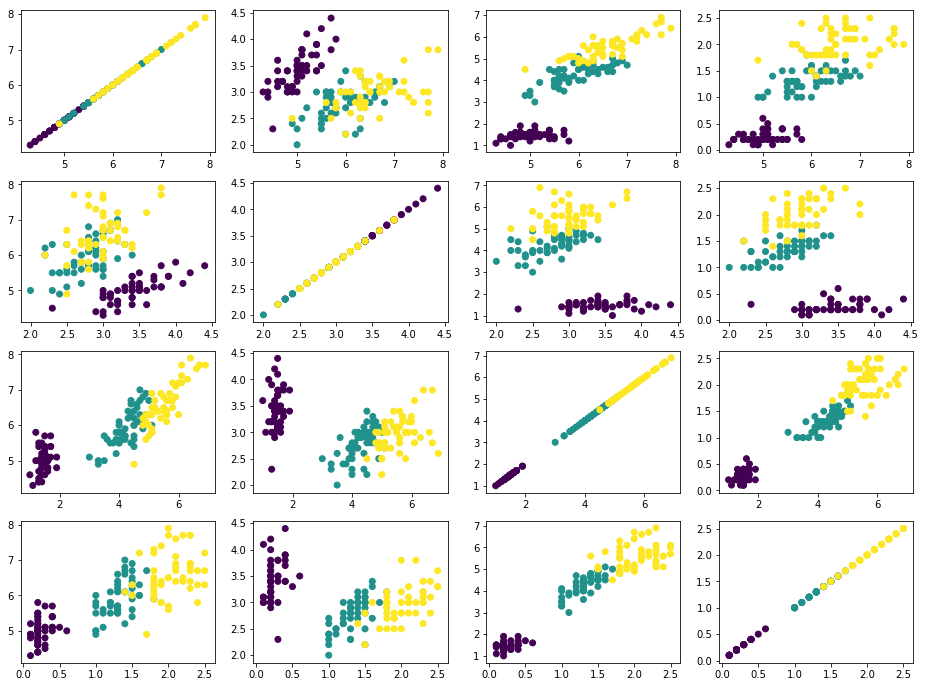

In [684]:
plt.figure(figsize=(16, 12))
for i in range(0,4):
    for j in range(0,4) : 
        plt.subplot(4,4,i*4+j+1)
        plt.scatter(X[:, i], X[:, j], c = Y)


<p style="text-align:justify;"> On remarque alors facilement les caractéristiques des différents types de fleurs. L'Iris Setosa représentée en violet sur les graphiques semble se distinguer particulièrement des deux autres types de fleurs, la longueur du sépale est petite mais large, et la longueur et largeur du pétale sont petites. Les deux autres types de fleurs partagent des caractéristiques communes comme la ongueur et largeur du sépale. Cependant l'Iris Virginia (en jaune sur les graphiques) possède une largeur et une longueur de pétale plus grande que l'Iris Versicolour.  

Visualiser les données en 2D permet donc d'identifier des caractéristiques pour les différentes classes de données à classifier.</p>

&nbsp;

<p style="text-align:justify;"> Il est aussi important de se rendre compte de la répartition des données à disposition. Pour ce faire, nous pouvons faire une rapide étude statistique unidimensionnelle en traçant les boîtes à moustaches pour nos 4 variables explicatives. Nous pourrons alors détecter d'éventuelles anomalies dans les données et identifier les écarts statistiques entre les différentes variables explicatives. </p>

sepal length (cm)  : 
 	 Moyenne : 5.84 
 	 Ecart-type : 0.83
sepal width (cm)  : 
 	 Moyenne : 3.05 
 	 Ecart-type : 0.43
petal length (cm)  : 
 	 Moyenne : 3.76 
 	 Ecart-type : 1.76
petal width (cm)  : 
 	 Moyenne : 1.20 
 	 Ecart-type : 0.76


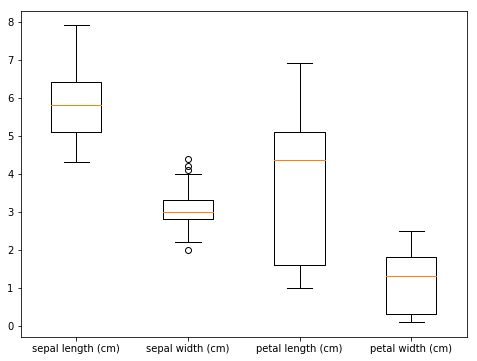

In [436]:
plt.figure(figsize=(8, 6))
box = plt.boxplot(X)
box = plt.xticks([1, 2, 3, 4], [iris.feature_names[0], iris.feature_names[1], iris.feature_names[2], iris.feature_names[3]])
for i in range(0,4):
    mean = np.mean(X[:,i])
    var = np.std(X[:,i])
    print(iris.feature_names[i], " : \n \t Moyenne : %.2f \n \t Ecart-type : %.2f" %(mean, var))

<p style="text-align:justify;"> Dans un premier temps, notons que nous n'identifions pas de valeurs aberrantes. De plus les variables sont dans le même ordre de grandeur, donc la normalisation des données n'aura pas une grande influence sur les résultats.</p>

&nbsp;


<p style="text-align:justify;"> Une analyse multivariée permet d'identifier les liaisons entre les variables et se faire une idée des variables à "filtrer". Un indicateur efficace est la matrice de corrélation. </p>

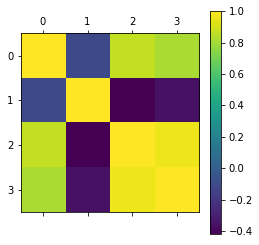

In [437]:
plt.matshow(np.corrcoef(X,rowvar=False))
plt.colorbar()
plt.show()

<p style="text-align:justify;"> Les variables 2 (longueur du pétale) et 3 (largeur du pétale) semblent très corrélées entre elles. On pouvait s'y attendre étant donnée la liaison linéaire très identifiable sur les graphiques permettant la visualisation en 2D pour ces paires de descripteurs. Ces deux variables ont donc le même impact sur la variable Y (elles apportent la même information), donc lorsque l'on appliquera des modèles, on pourrait en garder qu'une des deux. Cependant le nombre de données étant faible, l'intérêt de se séparer d'une variable est moindre. </p>


&nbsp;


&nbsp;


## Mise en place d’une méthode de classification des données



&nbsp;

<p style="text-align:justify;">  Dans cette partie, nous allons mettre en place une méthode de classification des données appelée "k plus proches voisins". Un objet d'entrée est classifié selon le résultat majoritaire des statistiques de classes d'appartenance de ses k plus proches voisins (la métrique utilisée sera la distance euclidienne). Si k = 1, alors l'objet est assigné à la classe d'appartenance de son proche voisin. </p>


&nbsp;

<p style="text-align:justify;">  La méthode sera la suivante. Le jeu de données va être découpé aléatoirement en 3 jeux de données. Un jeu de données d'apprentissage sur lequel le modèle sera appris, un jeu de données de validation sur lequel sera évalué le modèle. On sélectionnera le modèle qui a les meilleurs performances sur le jeu de données de validation. Et enfin un jeu de données test sur lequel sera testé le modèle finalement choisi. Le jeu de données test va donc être utilisé qu'une seule fois. </p>

&nbsp;

<p style="text-align:justify;">  Pour faire cette séparation en 3 jeux de données, nous utilisons la fonction *train_test_split* de *sklearn*. </p>

In [536]:
from sklearn.model_selection import train_test_split


Xa, Xv, Ya, Yv = train_test_split(X,Y)
Xa, X_test, Ya, Y_test = train_test_split(Xa,Ya)

&nbsp;


### Normalisation des données

&nbsp;

<p style="text-align:justify;"> Bien que cela ne soit pas forcément nécessaire dans cette étude car les données ont le même ordre de grandeur, nous allons normalisé les données. Nous allons dans un premier temps normaliser les données "à la main", puis en utilisant *sklearn*.</p>

#### A la main

&nbsp;

<p style="text-align:justify;"> On calcule la moyenne de $m_a \in \mathbb{R}^4$ et l'écart-type $\sigma_a \in \mathbb{R}^4$ des variables explicatives en utilisant seulement le jeu de données d'apprentissage. On normalise ensuite les jeux de données de validation et de test avec $m_a$ et $\sigma_a$. On affiche alors les moyennes avant et après normalisation. </p>

In [537]:
print(' -- Moyenne des variables explicatives sans normalisation -- \n')
print('Apprentissage : ')
print(Xa.mean(axis=0))
print('Validation : ')
print(Xv.mean(axis=0))
print('Test : ')
print(X_test.mean(axis=0))

m_a = [Xa[:,i].mean() for i in range(0,4)]
sigma_a = [Xa[:,i].std() for i in range(0,4)]
XaN = (Xa - m_a) / sigma_a
XvN = (Xv - m_a) / sigma_a
X_testN = (X_test - m_a) / sigma_a

print(' \n \n \n -- Moyenne des variables explicatives avec normalisation à la main -- \n')
print('Apprentissage : ')
print(XaN.mean(axis=0))
print('Validation : ')
print(XvN.mean(axis=0))
print('Test : ')
print(X_testN.mean(axis=0))

 -- Moyenne des variables explicatives sans normalisation -- 

Apprentissage : 
[5.88928571 3.06666667 3.73928571 1.16309524]
Validation : 
[5.76052632 3.04736842 3.78421053 1.27105263]
Test : 
[5.81785714 3.025      3.78214286 1.20714286]
 
 
 
 -- Moyenne des variables explicatives avec normalisation à la main -- 

Apprentissage : 
[ 1.98254112e-17  4.89687656e-16 -2.85485921e-16 -1.19943737e-16]
Validation : 
[-0.15576192 -0.04268885  0.0249207   0.14179052]
Test : 
[-0.08640807 -0.09216911  0.02377372  0.05785185]


On remarque que les données ont bien été normalisées, la moyenne des variables explicatives étant maintenant nulles.

&nbsp;


#### Avec Scikit Learn

&nbsp;

On peut aussi utiliser la fonction *StandardScaler* de *sklearn* pour normaliser les données.

In [538]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
scl.fit(Xa)

XaN_sk = scl.transform(Xa)
XvN_sk = scl.transform(Xv)
X_testN_sk = scl.transform(X_test)


print(' -- Moyenne des variables explicatives avec normalisation via sklearn --  \n')
print('Apprentissage : ')
print(XaN_sk.mean(axis=0))
print('Validation : ')
print(XvN_sk.mean(axis=0))
print('Test : ')
print(X_testN_sk.mean(axis=0))

 -- Moyenne des variables explicatives avec normalisation via sklearn --  

Apprentissage : 
[-1.02166952e-15  4.87705114e-16  1.71820230e-16 -6.85298379e-16]
Validation : 
[-0.15576192 -0.04268885  0.0249207   0.14179052]
Test : 
[-0.08640807 -0.09216911  0.02377372  0.05785185]


On retrouve alors les mêmes résultats que lors de la normalisation à la main pour les données test et de validation. Cependant il y a de très petites variations pour les données d'apprentissage, mais cela est de l'ordre de $10^{-15}$.

### Méthode des k plus proches voisins

&nbsp;

<p style="text-align:justify;"> Nous allons dans cette partie étudier la méthode des k plus proches voisins. Nous utiliserons la fonction *KNeighborsClassifier* de *sklearn*. En regardant la documentation sur cette fonction, on remarque que certains paramètres de la fonction peuvent être choisis comme le nombre k de voisins ou la métrique utilisée. Dans notre étude nous nous intéresserons à l'influence du nombre k de voisins sur les résultats, la métrique étant fixée (distance euclidienne).</p>

&nbsp;

<p style="text-align:justify;"> Nous définissons une fonction score qui permet de calculer l'erreur de validation comme suit : 
$$erreur_v = \frac{1}{N_v}\sum_{i=1}^{N_v}y_v(i) \neq \hat{y}_v(i)$$   

avec $N_v$ le nombre de points de l'ensemble $v$, $\hat{y}_v(i)$ et $y_v(i)$ respectivement la prédiction du label et le vrai label du $i$ème point dans $X_v$. </p>

In [539]:
def score(X1, X2):
    sum = 0
    for i in range(len(X1)):
        if (X1[i] == X2[i]):
            sum = sum + 1
    return sum/(len(X1))

&nbsp;

<p style="text-align:justify;"> Le meilleur $k$ est le $k$ qui donne le meilleur score sur le jeu de données de validation. Pour trouver le meilleur $k$, on utilisera dans notre programme une boucle qui boucle sur la valeur de $k$. La méthode des $kpp$ va être entrainée sur le jeu de données d'apprentissage, puis testée sur le jeu de données de validation. Le score obtenu sur le jeu de données validation sera stocké dans un tableau. Le meilleur $k$ sera donc celui qui permettra d'obtenir le meilleur score sur le jeu de données de validation. On pourra alors prédire la classe des données du jeu de test avec le classifieur des *kpp* entraîné sur le jeu de données d'apprentissage avec le $k$ optimal ainsi trouvé. Pour illuster l'importance d'optimiser le nombre $k$ de voisins sur le jeu de données de validation et pas sur le jeu de données d'apprentissage, on comparera le $k$ obtenu avec la méthode décrite précédemment et le score obtenu sur l'échantillon test.</p>

In [540]:
from sklearn.neighbors import KNeighborsClassifier
k_values = [i for i in range(3,30)]
perf_val = []
perf_app = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(XaN, Ya) 
    perf_app.append(score(knn.predict(XaN), Ya))
    perf_val.append(score(knn.predict(XvN), Yv))
best_k = k_values[np.argmax(perf_val)] #récupère le meilleur k
app_k = k_values[np.argmax(perf_app)]

print("k trouvé avec les données d'apprentissage : %d ---- score sur données d'apprentissage : %3f." % (app_k, max(perf_app)))
print("k trouvé avec les données de validation : %d ---- score sur données de validation : %3f." % (best_k, max(perf_val)))



best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(XaN, Ya)
print("Score des données test avec le k obtenu avec les données de validation : %f." %score(best_knn.predict(X_testN), Y_test))

app_knn = KNeighborsClassifier(n_neighbors=app_k)
app_knn.fit(XaN, Ya)
print("Score des données test avec le k obtenu avec les données d'apprentissage : %f." %score(app_knn.predict(X_testN), Y_test))


k trouvé avec les données d'apprentissage : 7 ---- score sur données d'apprentissage : 0.988095.
k trouvé avec les données de validation : 4 ---- score sur données de validation : 0.973684.
Score des données test avec le k obtenu avec les données de validation : 0.964286.
Score des données test avec le k obtenu avec les données d'apprentissage : 0.892857.


&nbsp;

<p style="text-align:justify;"> Ainsi, le $k$ qui maximise le score sur l'échantillon d'apprentissage est 7 et celui qui maximise le score sur l'échantillon de validation est $4$. Les scores obtenus sont respectivement 0.988 et 0.973, ce qui est excellent. En revanche, on remarque que le score obtenu sur l'échantillon test en entraînant le modèle sur le jeu d'apprentissage avec $k=4$ (0.964) est bien meilleure que celui obtenu avec $k=7$ (0.892). Cela illustre parfaitement bien l'importance d'optimiser les hyper paramètres avec un jeu de données de validation. 
Finalement avec nos données, la meilleure valeur de $k$ à choisir est 4.</p>

&nbsp;

<p style="text-align:justify;"> On peut alors tracer la courbe d'erreur d'apprentissage et la courbe d'erreur de validation en fonction de $k$.</p>

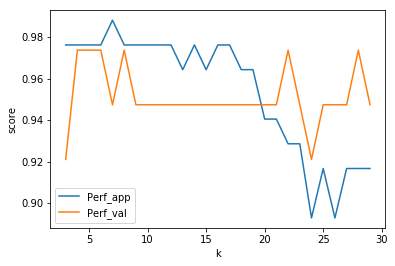

In [541]:
Courbe_erreur = plt.plot(k_values,perf_app, label = 'Perf_app' )
Courbe_erreur = plt.plot(k_values,perf_val, label = 'Perf_val'  )
Courbe_erreur = plt.legend()
Courbe_erreur = plt.xlabel("k")
Courbe_erreur = plt.ylabel("score")

&nbsp;

<p style="text-align:justify;"> Le $k$ optimal est le maximum de chaque courbe. On retrouve bien $k=4$ avec le score de validation et $k=7$ pour le score en apprentissage. </p>

&nbsp;

<p style="text-align:justify;"> En répétant l'opérations plusieurs fois (découpage Apprentissage/validation/Test), on observe que le $k$ optimal est différent à chaque fois et on obtient donc des résultats différents selon le découpage des données. Pour pallier ce problème et déterminer un $k$ optimal et robuste au découpage des données, on peut utiliser la méthode des *k-fold cross-validation*.  </p>

&nbsp;

<p style="text-align:justify;"> La méthode des k-fold cross-validation consiste à diviser l'échantillon original en $k$ échantillons, puis sélecitonner un des  $k$ échantillons comme ensemble de validation et les $k-1$ autres échantillons constitueront l'ensemble d'apprentissage. On calcule le score de performance sur cet echantillon de validation, puis on répète l'opération en sélectionnant un autre échantillon de validation parmi les $k-1$ échantillons qui n'ont pas encore été utilisés pour la validation du modèle. L'opération se répète ainsi $k$ fois pour qu'en fin de compte chaque sous-échantillon ait été utilisé exactement une fois comme ensemble de validation. La moyenne des $k$ erreurs est enfin calculée pour estimer l'erreur de prédiction. 
Dans un premier temps, on divise le dataset en deux, un dataset d'apprentissage et un dataset de test. On appelle la fonction KFold en précisant qu'on veut que le dataset d'apprentissage soit divisé en 3 sous échantillons. On boucle ensuite sur les résultats de l'appelle a la fonction *kf.split(X_app)* qui renvoie les indices des données qui vont servir au dataset de validation et d'apprentissage. Chaque donnée va donc être contenue une fois dans l'échantillon de validation et deux fois dans l'échantillon d'apprentissage. On utilise alors la méthode des *k ppv* sur chaque échantillon de validation en testant différentes valeurs de $k$ ( $k$ allant de 3 à 15), et on stocke tout cela dans la liste *perf_val*. La liste *perf_val* contient 3 listes qui contiennent le score de la méthode des *k ppv* pour différentes valeurs de k pour les 3 échantillons de validation utilisés par la méthode des *k folds*.</p>

In [984]:
X_app, X_test, Y_app, Y_test = train_test_split(X,Y)
scl = StandardScaler()

In [985]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
i = 1


k_values = [i for i in range(3,15)]
perf_val = [[], [], []]
decoupage = 0

for train , valid in kf.split(X_app):
    X_train = X_app[train,:]
    Y_train = Y_app[train]
    X_valid = X_app[valid,:]
    Y_valid = Y_app[valid]
    scl.fit(X_app)
    X_trainN = scl.transform(X_train)
    X_validN = scl.transform(X_valid)
    
    for k in k_values :
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_trainN, Y_train)
        perf_val[decoupage].append(knn.score(X_validN, Y_valid))
    decoupage += 1

&nbsp;

<p style="text-align:justify;"> On additionne alors les 3 listes de la liste *perf_val* puis on divise par le nombre de split utilisé dans la méthode des *k folds* à savoir 3. On obtient alors le score moyen pour chaque valeur de *k*. Le meilleur *k* sera donc celui qui maximise le score contenu dans la liste *perf_globale*.</p>

In [986]:
perf_globale = np.zeros((len(k_values), 1))
for i in range(0, len(k_values)):
    perf_globale[i] = perf_val[0][i] + perf_val[1][i] + perf_val[2][i]
    perf_globale[i] /= 3
k_opt = k_values[np.argmax(perf_globale)]
print('Le k optimal est %d. ' %k_opt)

Le k optimal est 7. 


&nbsp;

<p style="text-align:justify;"> On peut afficher la courbe du score en fonction de $k$. Le pic le plus haut correspond donc au $k$ optimal.</p>

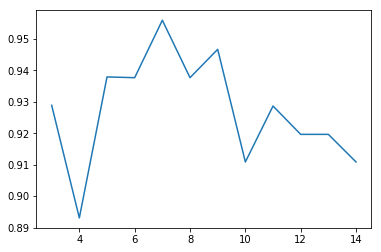

In [987]:
plt.plot(k_values, perf_globale)
plt.show()
k_opt = k_values[np.argmax(perf_globale)]

&nbsp;

<p style="text-align:justify;"> On peut aussi afficher le score en fonction de $k$ pour chaque échantillon de validation de la méthode des *k folds*.</p>

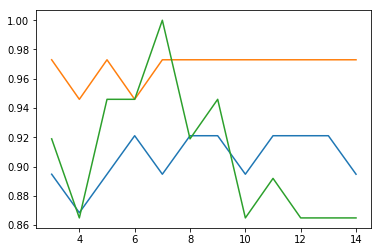

In [988]:
plt.plot(k_values, perf_val[0])
plt.plot(k_values, perf_val[1])
plt.plot(k_values, perf_val[2])
plt.show()

&nbsp;

<p style="text-align:justify;"> Cette méthode permet donc de trouver un k-optimal robuste au découpage des données. On peut alors évaluer les performances du modèle avec le k optimal sur l'ensemble de test et sur celui d'apprentissage. </p>

In [989]:
scl.fit(X_app)
X_appN = scl.transform(X_app)
X_testN = scl.transform(X_test)

app_knn = KNeighborsClassifier(n_neighbors=k_opt)
app_knn.fit(X_appN, Y_app)
print("Score obtenu sur l'échantillon d'apprentissage avec le k obtenu avec la méthode des k folds : %f." %score(app_knn.predict(X_appN), Y_app))
print("Score obtenu sur l'échantillon test avec le k obtenu avec la méthode des k folds : %f." %score(app_knn.predict(X_testN), Y_test))


Score obtenu sur l'échantillon d'apprentissage avec le k obtenu avec la méthode des k folds : 0.964286.
Score obtenu sur l'échantillon test avec le k obtenu avec la méthode des k folds : 0.973684.


&nbsp;

## Données WhiteW

&nbsp;

&nbsp;

<p style="text-align:justify;"> Les données WhiteW sont des résultats d'analyse chimique de vins produits dans une zone spécifique en Italie. 3 types de vins sont représentés par 178 échantillons qui sont les résultats de 13 analyses chimiques enregistrés pour chaque échantillon.   </p>

&nbsp;

<p style="text-align:justify;"> On charge dans un premier temps les données : </p>

In [996]:
def load_wine():
    dataset_url= 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
    myData = None
    myData=pd.read_csv(dataset_url,names=['quality','Alcohol','Malic acid','Ash','Alcalinity of ash  ','Magnesium','Total phenols','Flavanoids','Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline'],header=None)    
    y=myData.quality
    X=myData.drop('quality',axis=1)
    return X, y

In [1003]:
X, Y = load_wine()

&nbsp;

<p style="text-align:justify;"> On peut maintenant afficher les différentes variables explicatives du jeu de données et leurs caractéristiques.</p>

In [1023]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(2)
memory usage: 18.2 KB
None


<p style="text-align:justify;"> On remarque qu'il n'y a aucune données manquantes et que les données sont de types numériques. Les intitulés des colonnes sont aussi affichés, ce sont des indicateurs chimiques tels que le degré d'alcohol ou la teneur en magnesium par exemple. Tout ces informations permettent de classifier 3 types de vin.</p>

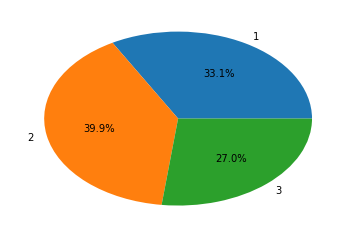

(178,)


In [1022]:
Y_liste = Y.values.tolist()
Y_liste.count(1)

labels = '1', '2', '3'
sizes = [Y_liste.count(1), Y_liste.count(2), Y_liste.count(3)]
plt.pie(sizes, labels = labels, autopct='%1.1f%%')
plt.show()
print(Y.shape)

<p style="text-align:justify;"> Les noms des vins ont été labelisés pour en faire une variable catégorique. Il y a 3 classes de vins, assez bien répartis. </p>

&nbsp;

<p style="text-align:justify;"> On va maintenant regarder la distribution des 13 variables explicatives en affichant les boxplots.</p>

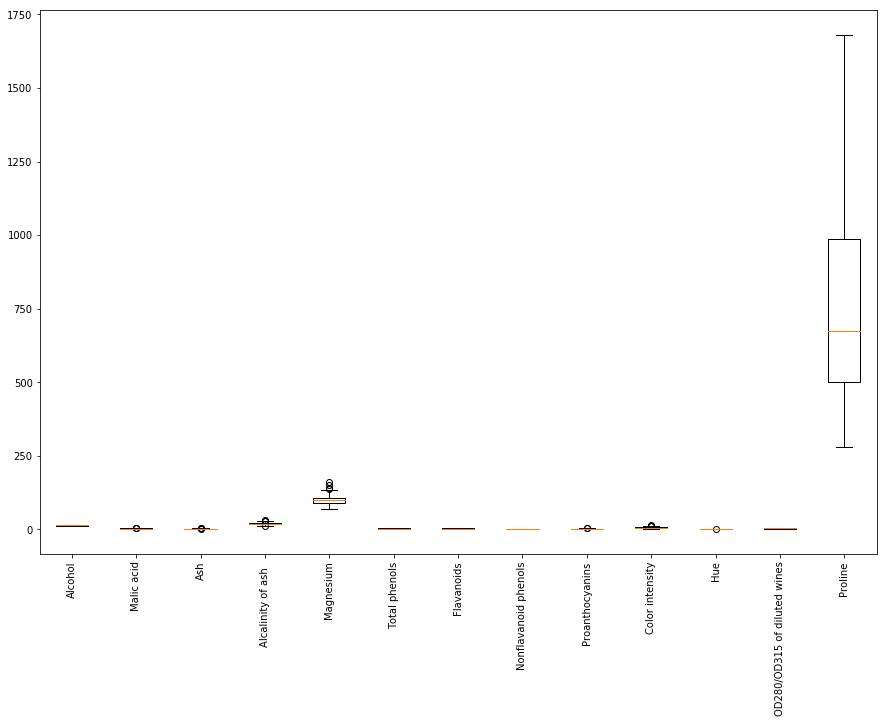

In [691]:
plt.figure(figsize=(15, 10))
box = plt.boxplot(X.values)
box = plt.xticks([i + 1 for i in range(0,13)], X.columns, rotation='vertical')

<p style="text-align:justify;"> On remarque que les boxplots ne sont pas lisibles à cause de la variable "Proline" qui prend des valeurs beaucoup plus grandes que les autres variables. Ce premier graphique nous indique donc qu'il sera important de normaliser les données pour avoir des valeurs dans le même ordre de grandeur.</p>

&nbsp;

<p style="text-align:justify;"> On affiche alors les boxplot un par un pour repérer d'éventuelles valeurs aberrantes.</p>

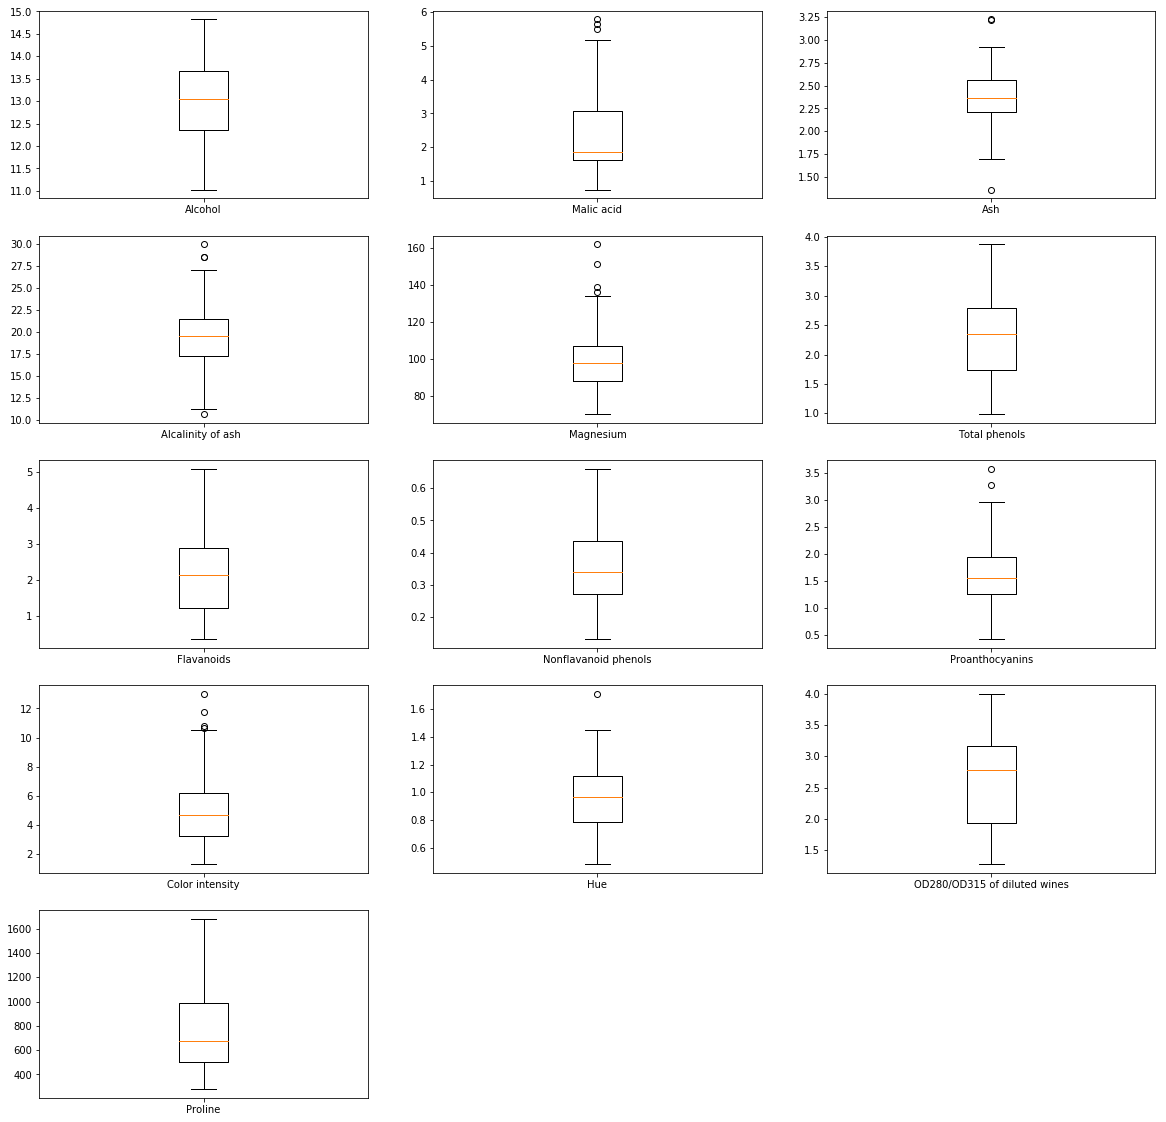

In [719]:
plt.figure(figsize=(20, 20))
for i in range (1,14) :
    plt.subplot(5,3,i)
    plt.boxplot(X.values[:,i-1], labels= [X.columns[i-1]])

<p style="text-align:justify;"> On n'observe aucune valeur aberrante ou anormale.</p>

&nbsp;

<p style="text-align:justify;"> On va maintenant afficher la matrice des corrélations entre les variables explicatives. Deux variables très corrélées vont potentiellement apporter la même information et on pourra alors s'en séparer d'une pour ne pas compléxifier notre modèle.</p>

In [741]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Alcohol,1,0.094,0.21,-0.31,0.27,0.29,0.24,-0.16,0.14,0.55,-0.072,0.072,0.64
Malic acid,0.094,1,0.16,0.29,-0.055,-0.34,-0.41,0.29,-0.22,0.25,-0.56,-0.37,-0.19
Ash,0.21,0.16,1,0.44,0.29,0.13,0.12,0.19,0.0097,0.26,-0.075,0.0039,0.22
Alcalinity of ash,-0.31,0.29,0.44,1,-0.083,-0.32,-0.35,0.36,-0.2,0.019,-0.27,-0.28,-0.44
Magnesium,0.27,-0.055,0.29,-0.083,1,0.21,0.2,-0.26,0.24,0.2,0.055,0.066,0.39
Total phenols,0.29,-0.34,0.13,-0.32,0.21,1,0.86,-0.45,0.61,-0.055,0.43,0.7,0.5
Flavanoids,0.24,-0.41,0.12,-0.35,0.2,0.86,1,-0.54,0.65,-0.17,0.54,0.79,0.49
Nonflavanoid phenols,-0.16,0.29,0.19,0.36,-0.26,-0.45,-0.54,1,-0.37,0.14,-0.26,-0.5,-0.31
Proanthocyanins,0.14,-0.22,0.0097,-0.2,0.24,0.61,0.65,-0.37,1,-0.025,0.3,0.52,0.33
Color intensity,0.55,0.25,0.26,0.019,0.2,-0.055,-0.17,0.14,-0.025,1,-0.52,-0.43,0.32


<p style="text-align:justify;"> On observe deux variables corrélées entre elles à hauteur de 86%. </p>

<function matplotlib.pyplot.show>

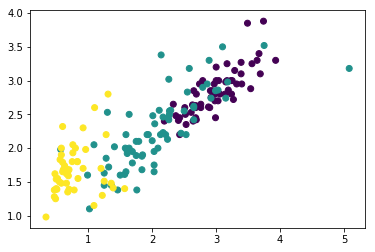

In [1024]:

plt.scatter(X.values[:, 6], X.values[:, 5], c = Y)

plt.show

<p style="text-align:justify;"> On affiche alors ces deux variables l'une en fonction de l'autre et on observe effectivement une légère liaison linéaire entre les deux. On peut discuter de l'intéret de garder ces deux variables dans notre modèle. Dans les livres de statistiques il est indiqué que deux variables qui donnent la même information ont un coefficient de corrélation de l'ordre de 95%. On est ici qu'à 86% et nous n'avons pas un grand nombre de données (178) donc on va garder ces deux variables dans notre modèle.</p>
&nbsp;


&nbsp;

<p style="text-align:justify;">  On a vu que les données n'ont pas toutes le même ordre de grandeur. On va donc normaliser les données et s'assurer qu'elles sont bien normalisées. On va découper notre jeu de données en 3, un jeu d'apprentissage, un jeu de validation, et un jeu de test. </p>

In [1025]:
X_app, X_val, Y_app, Y_val = train_test_split(X.values,Y.values)
X_app, X_test, Y_app, Y_test = train_test_split(X_app,Y_app)
scl = StandardScaler()

In [1026]:
print(' -- Moyenne des variables explicatives sans normalisation -- \n')
print('Apprentissage : ')
print(X_app.mean(axis=0))
print('\n Validation : ')
print(X_val.mean(axis=0))
print('\n Test : ')
print(X_test.mean(axis=0))

m_a = [X_app[:,i].mean() for i in range(0,13)]
sigma_a = [X_app[:,i].std() for i in range(0,13)]
X_appN = (X_app - m_a) / sigma_a
X_valN = (X_val - m_a) / sigma_a
X_testN = (X_test - m_a) / sigma_a

print(' \n \n \n -- Moyenne des variables explicatives avec normalisation à la main -- \n')
print('Apprentissage : ')
print(X_appN.mean(axis=0))
print(' \n Validation : ')
print(X_valN.mean(axis=0))
print('\n Test : ')
print(X_testN.mean(axis=0))

 -- Moyenne des variables explicatives sans normalisation -- 

Apprentissage : 
[1.29605051e+01 2.26878788e+00 2.36696970e+00 1.96000000e+01
 9.85858586e+01 2.33232323e+00 2.11070707e+00 3.51515152e-01
 1.59121212e+00 5.06070706e+00 9.57070707e-01 2.64505051e+00
 7.38464646e+02]

 Validation : 
[1.30955556e+01 2.54844444e+00 2.33777778e+00 1.91644444e+01
 1.00400000e+02 2.21488889e+00 1.92288889e+00 3.64444444e-01
 1.54622222e+00 4.89711111e+00 9.48133333e-01 2.55511111e+00
 7.54844444e+02]

 Test : 
[1.29917647e+01 2.25235294e+00 2.40323529e+00 1.96264706e+01
 1.02235294e+02 2.29294118e+00 1.93294118e+00 3.88529412e-01
 1.64911765e+00 5.26352941e+00 9.70882353e-01 2.58941176e+00
 7.60911765e+02]
 
 
 
 -- Moyenne des variables explicatives avec normalisation à la main -- 

Apprentissage : 
[-1.94232957e-15 -2.59893117e-16 -7.73791805e-16 -4.09605010e-16
 -1.71579922e-16 -7.51363057e-16  1.88401483e-16  1.36815363e-16
 -1.83915733e-16  8.97149919e-18 -5.00161080e-16 -3.65588592e-16
  1

&nbsp;

<p style="text-align:justify;">  On obtient donc une moyenne d'environ 0 pour les variables explicatives des 3 jeux de données.</p>

&nbsp;

&nbsp;

<p style="text-align:justify;">  On va maintenant créer un modèle de classification des données. Nous allons utiliser la méthode des k plus proches voisins. Pour ce faire, nous allons procéder de la même façon que dans la partie précédente en utilisant la méthode des *k folds* pour trouver le nombre *k* optimal de voisins à choisir comme hyper paramètre de la méthode des *k ppv*. Nous n'allons pas nous servir des jeux de données créés précedemment. Ils ont été créés pour répondre à la question du TP mais comme nous allons utiliser *k folds*, nous allons séparer notre jeu de données en un jeu d'apprentissage et un jeu test. En effet *k folds* va utiliser des échantillons de validation avec le jeu d'apprentissage, comme nous avons expliquer en détail précédemment. On choisi comme nombre de splits 5 dans la fonction *KFold*. Dans la documentation il est dit que généralement 10 est choisi comme nombre de split. Cependant nous possédons que 178 données, et séparer l'échantillon d'apprentissage en 10 conduirait à des échantillons de validation petits. </p>

In [1031]:
X_app, X_test, Y_app, Y_test = train_test_split(X.values,Y.values)
scl = StandardScaler()

In [1032]:
kf = KFold(n_splits=5)
i = 1


k_values = [i for i in range(3,15)]
perf_val = [[], [], [], [], []]
decoupage = 0

for train , valid in kf.split(X_app):
    X_train = X_app[train,:]
    Y_train = Y_app[train]
    X_valid = X_app[valid,:]
    Y_valid = Y_app[valid]
    scl.fit(X_app)
    X_trainN = scl.transform(X_train)
    X_validN = scl.transform(X_valid)
    
    for k in k_values :
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_trainN, Y_train)
        perf_val[decoupage].append(knn.score(X_validN, Y_valid))
    decoupage += 1

In [1036]:
perf_globale = np.zeros((len(k_values), 1))
for i in range(0, len(k_values)):
    perf_globale[i] = perf_val[0][i] + perf_val[1][i] + perf_val[2][i] + perf_val[3][i] + perf_val[4][i] 
    perf_globale[i] /= 5
k_optimal = k_values[np.argmax(perf_globale)]
print('Le k optimal est %d. ' %k_optimal)

Le k optimal est 7. 


&nbsp;

<p style="text-align:justify;"> On peut afficher la courbe du score en fonction de $k$. Le pic le plus haut correspond donc au $k$ optimal.</p>

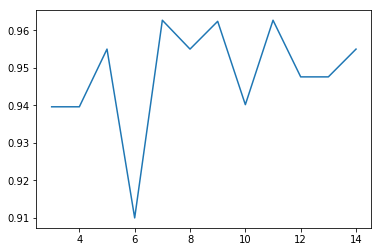

In [1037]:
plt.plot(k_values, perf_globale)
plt.show()


&nbsp;

<p style="text-align:justify;"> On peut aussi afficher la courbe du score des 5 échantillons de validation en fonction de $k$.</p>

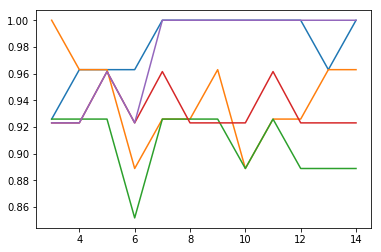

In [1038]:
plt.plot(k_values, perf_val[0])
plt.plot(k_values, perf_val[1])
plt.plot(k_values, perf_val[2])
plt.plot(k_values, perf_val[3])
plt.plot(k_values, perf_val[4])

plt.show()

In [1039]:
print('Le k optimal trouvé avec la méthode des k folds est %d.' % k_optimal)

scl.fit(X_app)
X_appN = scl.transform(X_app)
X_testN = scl.transform(X_test)

app_knn = KNeighborsClassifier(n_neighbors=k_optimal)
app_knn.fit(X_appN, Y_app)
print("Score sur données d'apprentissage' : %3f." %score(app_knn.predict(X_appN), Y_app))
print("Score sur les données test : %f." %score(app_knn.predict(X_testN), Y_test))


Le k optimal trouvé avec la méthode des k folds est 7.
Score sur données d'apprentissage' : 0.984962.
Score sur les données test : 0.955556.


&nbsp;

<p style="text-align:justify;"> On obtient alors un très bon score en prédiction sur notre jeu de données test. 95.5% des données test ont été correctement classifiés.</p>

&nbsp;

&nbsp;

<p style="text-align:justify;"> Afin d'illustrer l'importance de normaliser les données lorsqu'elles ont un ordre de grandeur différent les unes des autres, nous allons appliquer la méthode des *k ppv* sur le même ensemble d'apprentissage et de test que précédemment en prenant comme valeur de *k* le *k* optimal trouvé avec la méthode des *k folds*. Mais cette fois ci, nous ne normalisons pas nos données d'apprentissage et de test. Observons les résultats :</p>

In [1040]:
print('Le k optimal trouvé avec la méthode des k folds est %d.' % k_optimal)

app_knn = KNeighborsClassifier(n_neighbors=k_optimal)
app_knn.fit(X_app, Y_app)
print("Score sur données d'apprentissage' : %3f." %score(app_knn.predict(X_app), Y_app))
print("Score sur les données test : %f." %score(app_knn.predict(X_test), Y_test))

Le k optimal trouvé avec la méthode des k folds est 7.
Score sur données d'apprentissage' : 0.751880.
Score sur les données test : 0.755556.


&nbsp;

<p style="text-align:justify;"> On obtient alors un score de prédiction sur l'échantillon test de seulement 75%, ce qui est 20% plus faible que lorsque les données ont été normalisées. On peut donc conclure que normaliser les données lorsqu'elles ont un ordre de grandeur différent, permet d'augmenter significativement les performances en classification.</p>